# Parameterizing Neural Power Spectra

SfN 2018 NanoSymposium: Oscillation Methods

Thomas Donoghue

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt

from neurodsp.sim import sim_noisy_bursty_oscillator
from neurodsp.spectral import psd

from fooof import FOOOF
from fooof.utils import trim_spectrum
from fooof.synth import gen_power_spectrum
from fooof.analysis import get_band_peak
from fooof.plts.spectra import plot_spectrum, plot_spectra, plot_spectrum_shading, plot_spectra_shading

### Neural Time Series

In [192]:
# Set the random seed for simulations
import numpy as np
np.random.seed(13)

In [193]:
# Generate a noisy oscillation signal, 3 seconds of 10Hz, sampled @ 1000 Hz
osc_freq, sig_length, s_rate = 10, 10, 1000
signal = sim_noisy_bursty_oscillator(freq=osc_freq, T=sig_length, Fs=s_rate, prob_enter_burst=0.3, SNR=2.5)

In [194]:
def plot_time_series(signal):
    time_series_plot = plt.figure(figsize=[18, 6])
    plt.plot(signal, color='#21437a')
    plt.xlim([0, 5000]);
    ax = plt.gca()
    ax.set_axis_off()

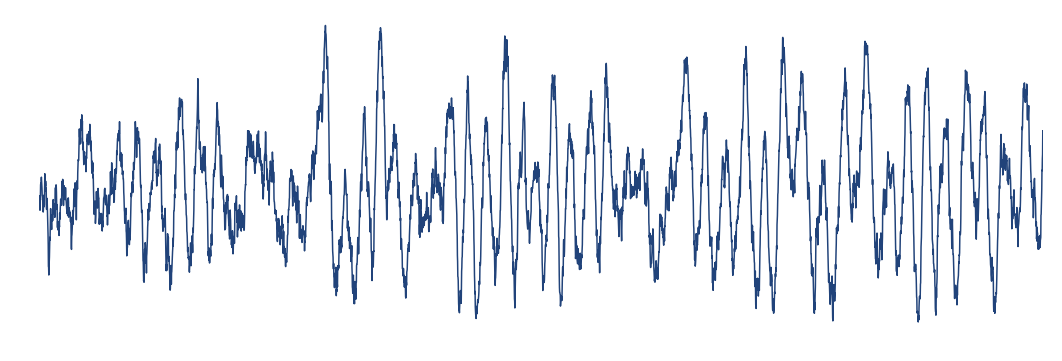

In [195]:
plot_time_series(signal)

## Neural Power Spectra

In [196]:
# Create a power spectrum of our signal
fs1, ps1 = psd(signal, s_rate)

In [197]:
# Trim spectrum to be only between 3 & 40 Hz
fs1, ps1 = trim_spectrum(fs1, ps1, [3, 40])

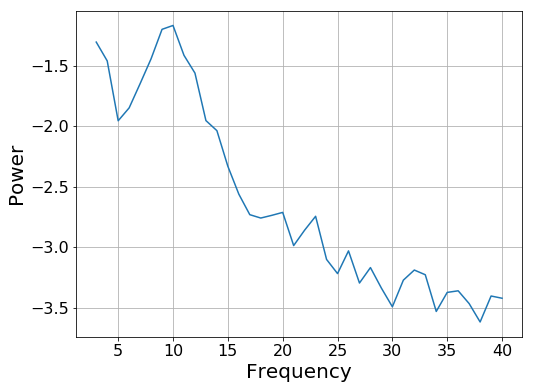

In [198]:
plot_spectrum(fs1, ps1, log_powers=True, ax=plt.figure(figsize=[8, 6]).gca()) 

## Analysis: Measure Band Specific Power

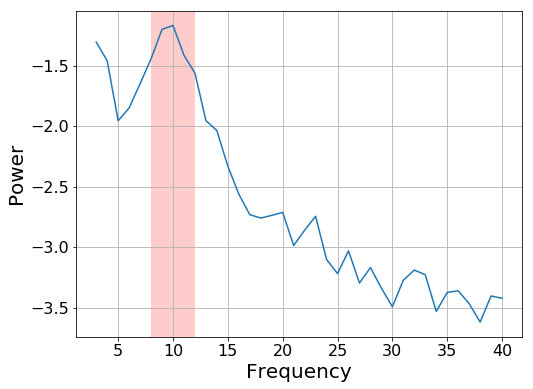

In [199]:
plot_spectrum_shading(fs1, ps1, [8, 12], log_powers=True, ax=plt.figure(figsize=[8, 6]).gca()) 

In [138]:
from neurodsp import amp_by_time

In [153]:
amp_signal = amp_by_time(signal, s_rate, [8, 12])
avg_power = sum(amp_signal) / len(amp_signal)

print(avg_power)

0.648888520229


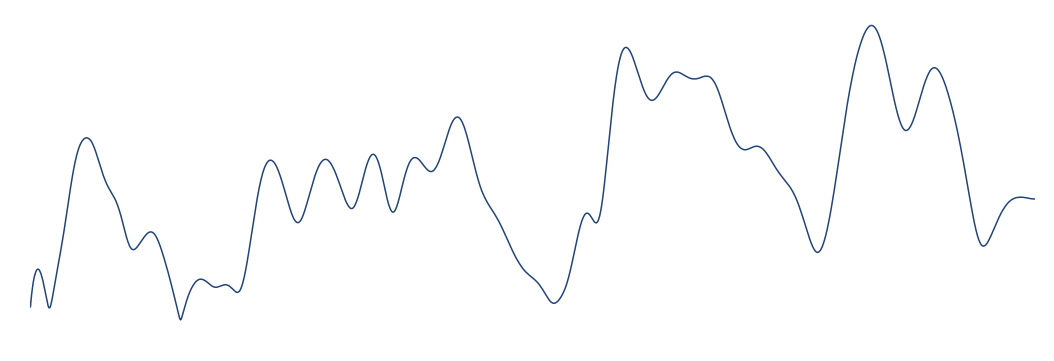

In [149]:
plot_time_series(amp_signal)

In [141]:
amp_by_time?

In [126]:
# Generation Settings
nlv = 0
f_res = 0.1
f_range = [3, 30]

# Create base line power spectrum
fs, ps_base = gen_power_spectrum(f_range, [0, 1.5], [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)

# Create comparison power spectra
_, ps_ap = gen_power_spectrum(f_range, [0, 1.5],   [[10, 0.31, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_af = gen_power_spectrum(f_range, [0, 1.5],   [[11.75, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_of = gen_power_spectrum(f_range, [-0.125, 1.5], [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_sl = gen_power_spectrum(f_range, [-0.87, 0.75],   [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)

In [127]:
def comparison_fig():
    title_settings = {'fontsize' : 20}#, 'fontweight': 'bold'}

    comparison_fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plot_spectra_shading(fs, [ps_base, ps_ap], [8, 12], log_freqs=True, log_powers=True, ax=ax[0, 0])
    ax[0, 0].set_title('Alpha Power Decrease', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_af], [8, 12], log_freqs=True, log_powers=True, ax=ax[0, 1])
    ax[0, 1].set_title('Alpha Frequency Shift', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_of], [8, 12], log_freqs=True, log_powers=True, ax=ax[1, 0])
    ax[1, 0].set_title('Offset Shift', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_sl], [8, 12], log_freqs=True, log_powers=True, ax=ax[1, 1])
    ax[1, 1].set_title('Slope Rotation', **title_settings)

    # Drop axis labels 
    for aa in ax.reshape(-1): 
        aa.xaxis.label.set_visible(False)
        aa.yaxis.label.set_visible(False)

    comparison_fig.subplots_adjust(hspace=.2)
    comparison_fig.subplots_adjust(wspace=.3)

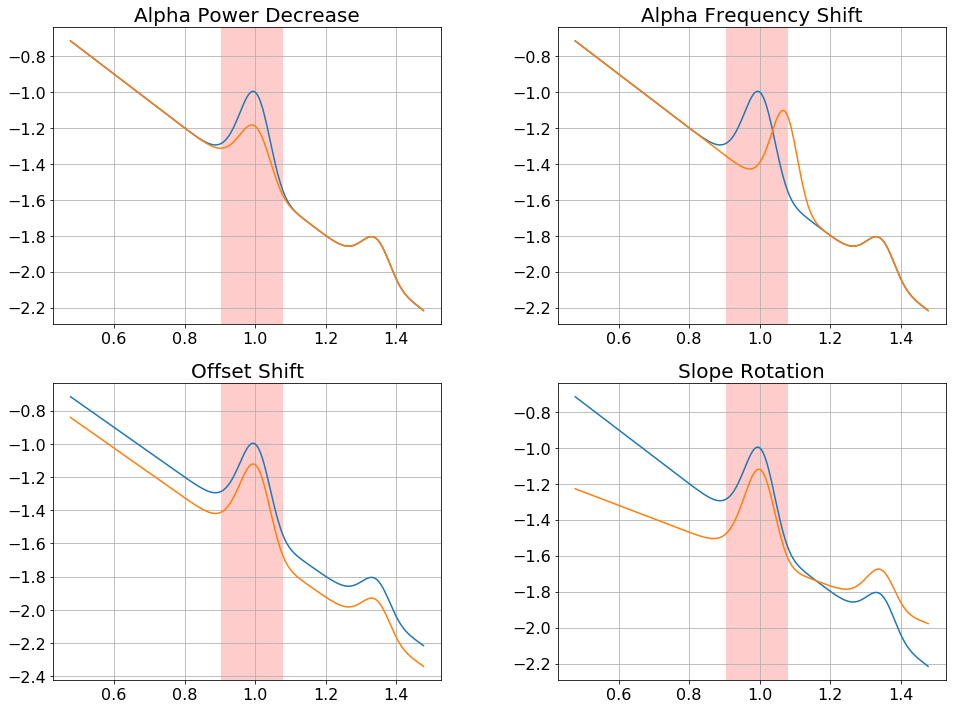

In [128]:
comparison_fig()

## Fitting Oscillations & One-Over F

In [129]:
# Initialize & fit FOOOF model
fm = FOOOF(verbose=False)
fm.fit(fs1, ps1)

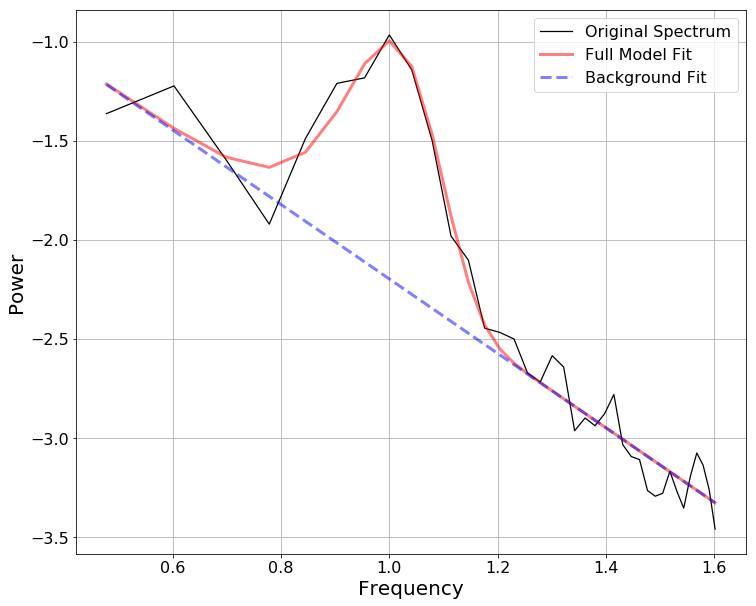

In [132]:
# Plot model fit results
fm.plot(plt_log=True)

In [133]:
# Print out the quantitative model fit results
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.3207, 1.8764                                          
                                                                                                  
                                       1 peaks were found:                                        
          

## Fitting FOOOF Models

In [134]:
# Initialize FOOOF models
fm1, fm2 = FOOOF(), FOOOF()

In [135]:
# Fit FOOOF models
fm1.fit(fs, ps_base)
fm2.fit(fs, ps_sl)

## Comparing FOOOF Ouputs

In [136]:
# Compare alpha
print(get_band_peak(fm1.peak_params_, [8, 12]))
print(get_band_peak(fm2.peak_params_, [8, 12]))

[ 9.99573602  0.4909675   1.93348706]
[ 9.99573601  0.4909675   1.93348706]


In [137]:
# Compare aperiodic component
print(fm1.background_params_)
print(fm2.background_params_)

[-0.00634603  1.48672038]
[-0.87634604  0.73672037]


## Why Use FOOOF?

- It fully parameterizes the power spectra
- Does not require prior specification of oscillation bands
- Explicitly controls for confounds between periodic & aperiodic components

## Parameterizing Neural Power Spectra

Addresses confounds in current approaches:
- Slope Methods
- BandRatios


Productively:
- Improved behavioural decoding with parameterized spectra
- Novel reports of oscillation & 1/f properties &  topographies

_All of the above currently in prep_. 

# The End